# Hardware-Tailored MoE Routing Analysis
Metrics and routing heatmap for dense vs RFT MoE.

{
  "dense_ce": 2.4096582233905792,
  "dense_ppl": 11.130156517028809,
  "moe_ce": 2.4694037795066834,
  "moe_ppl": 11.815400123596191,
  "kl_dense_moe": 0.05228637512773275,
  "heatmap": [
    [
      0.50240478515625,
      6.103515625e-05
    ],
    [
      0.00042724609375,
      0.49710693359375
    ]
  ]
}


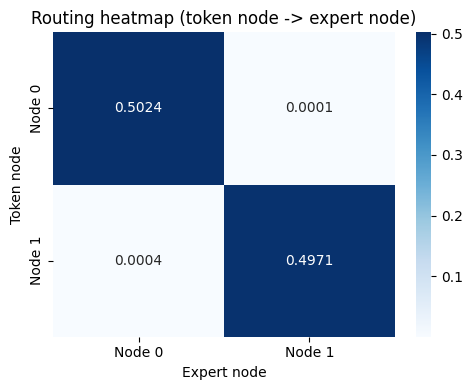

In [2]:
import os, sys, json
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

os.environ.setdefault("TOKENIZERS_PARALLELISM", "false")
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from rft_moe.data.dataset import build_dataloader, load_tinystories_tokens
from rft_moe.modeling.gpt import GPT, GPTConfig
from rft_moe.virtual_cluster import VirtualClusterConfig, VirtualClusterEnv
from rft_moe.utils.common import get_device

device = get_device()

# Paths
dense_ckpt = "../checkpoints/dense_baseline.pt"
moe_ckpt = "../checkpoints/moe_rft_fixed_lambda.pt"  # adjust as needed

# Data
block_size = 256
batch_size = 8
num_batches = 20
tokens, vocab_size = load_tinystories_tokens(tokenizer_name="gpt2", block_size=block_size, num_samples=50000)
dl = build_dataloader(tokens, block_size=block_size, batch_size=batch_size, shuffle=False, num_workers=2)

# Models
dense_cfg = GPTConfig(vocab_size=vocab_size, block_size=block_size, use_moe=False)
moe_cfg = GPTConfig(vocab_size=vocab_size, block_size=block_size, use_moe=True, num_experts=8, num_nodes=2)
dense = GPT(dense_cfg).to(device)
moe = GPT(moe_cfg).to(device)
dense.load_state_dict(torch.load(dense_ckpt, map_location=device).get("model", torch.load(dense_ckpt)))
moe.load_state_dict(torch.load(moe_ckpt, map_location=device).get("model", torch.load(moe_ckpt)))
dense.eval(); moe.eval();

cluster = VirtualClusterEnv(VirtualClusterConfig(num_experts=8, num_nodes=2))

ce_dense, ce_moe, kl_vals = [], [], []
heatmap = np.zeros((cluster.config.num_nodes, cluster.config.num_nodes))
total_slots = 0

with torch.no_grad():
    for idx, (x, y) in enumerate(dl):
        if idx >= num_batches:
            break
        x = x.to(device); y = y.to(device)
        token_nodes = torch.randint(low=0, high=cluster.config.num_nodes, size=(x.size(0), x.size(1)), device=device)
        ld, _, _ = dense(x, targets=None)
        lm, _, routers = moe(x, targets=None, token_nodes=token_nodes, return_router_outputs=True)

        eff_len = min(ld.size(1) - 1, y.size(1))
        ce_dense.append(F.cross_entropy(ld[:, :eff_len, :].reshape(-1, ld.size(-1)), y[:, :eff_len].reshape(-1)).item())
        ce_moe.append(F.cross_entropy(lm[:, :eff_len, :].reshape(-1, lm.size(-1)), y[:, :eff_len].reshape(-1)).item())

        p = torch.log_softmax(ld[:, :eff_len, :], dim=-1)
        q = torch.log_softmax(lm[:, :eff_len, :], dim=-1)
        kl_tok = torch.exp(p) * (p - q)
        kl_vals.append(kl_tok.sum(dim=-1).mean().item())

        if routers:
            router = routers[0]
            selected = router.selected_experts  # (B, T, k)
            expert_nodes = cluster.expert_to_node.to(device)[selected]
            for src in range(cluster.config.num_nodes):
                for dst in range(cluster.config.num_nodes):
                    count = ((token_nodes.unsqueeze(-1) == src) & (expert_nodes == dst)).sum().item()
                    heatmap[src, dst] += count
            total_slots += x.numel() * selected.size(-1)

mean_ce_dense = float(np.mean(ce_dense))
mean_ce_moe = float(np.mean(ce_moe))
mean_kl = float(np.mean(kl_vals))
heatmap_norm = heatmap / max(total_slots, 1)

print(json.dumps({
    "dense_ce": mean_ce_dense,
    "dense_ppl": float(torch.exp(torch.tensor(mean_ce_dense))),
    "moe_ce": mean_ce_moe,
    "moe_ppl": float(torch.exp(torch.tensor(mean_ce_moe))),
    "kl_dense_moe": mean_kl,
    "heatmap": heatmap_norm.tolist(),
}, indent=2))

plt.figure(figsize=(5,4))
sns.heatmap(heatmap_norm, annot=True, fmt=".4f", cmap="Blues",
            xticklabels=["Node 0", "Node 1"], yticklabels=["Node 0", "Node 1"])
plt.title("Routing heatmap (token node -> expert node)")
plt.xlabel("Expert node"); plt.ylabel("Token node")
plt.tight_layout()
plt.show()
